In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests, csv
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.experimental import completer
from shapely.geometry import Point, Polygon

## Data Sources
Census_total_jobs = https://data.census.gov/cedsci/table?q=United%20States&tid=ACSDP5Y2019.DP05

Lodes_crosswalk = https://lehd.ces.census.gov/data/#lodes

Census_tracts = https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

Primary List of California Transit Providers - Overview.csv  = https://docs.google.com/spreadsheets/d/105oar4q_Z3yihDeUlP-VnYpJ0N9Mfs7-q4TnribqYLU/edit#gid=471807468

Primary List of California Transit Providers - NTD Stats.csv = https://docs.google.com/spreadsheets/d/105oar4q_Z3yihDeUlP-VnYpJ0N9Mfs7-q4TnribqYLU/edit#gid=406295182

In [2]:
census_total_jobs = pd.read_csv("calitp_acs5_tracts.csv")
lodes_crosswalk = pd.read_csv("ca_xwalk_geoid_ct.csv")
transit = pd.read_csv("Primary List of California Transit Providers - Overview.csv")

census_tracts = geopandas.read_file('census_tracts/tl_2020_06_tract10.shp')

/Users/natalyadiaz/Professional/Cal-ITP/data-analyses/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (28,29,30,38) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:

census_lodes_data = pd.merge(census_total_jobs, lodes_crosswalk, on="GEOID", how='inner')
census_tracts.columns = census_tracts.columns.str.replace('GEOID10', 'GEOID')
census_tracts['GEOID'] = census_tracts['GEOID'].astype(int)
census_tracts_data = pd.merge(census_lodes_data, census_tracts, on="GEOID", how = 'inner')

# What is the number of transit services which have demand-responsive transit?

In [4]:
has_demand_responsive = transit.Modes.str.contains("DR",  na = False)
transit['has_demand_responsive'] = has_demand_responsive
transit.has_demand_responsive.value_counts()

True     201
False    199
Name: has_demand_responsive, dtype: int64

## 201 out of 300 have demand responsive

# What is the Percent of California( by area, population, employment) not served by fixed-route transit service?

### What is the percent of california served by fixed-route transit service 

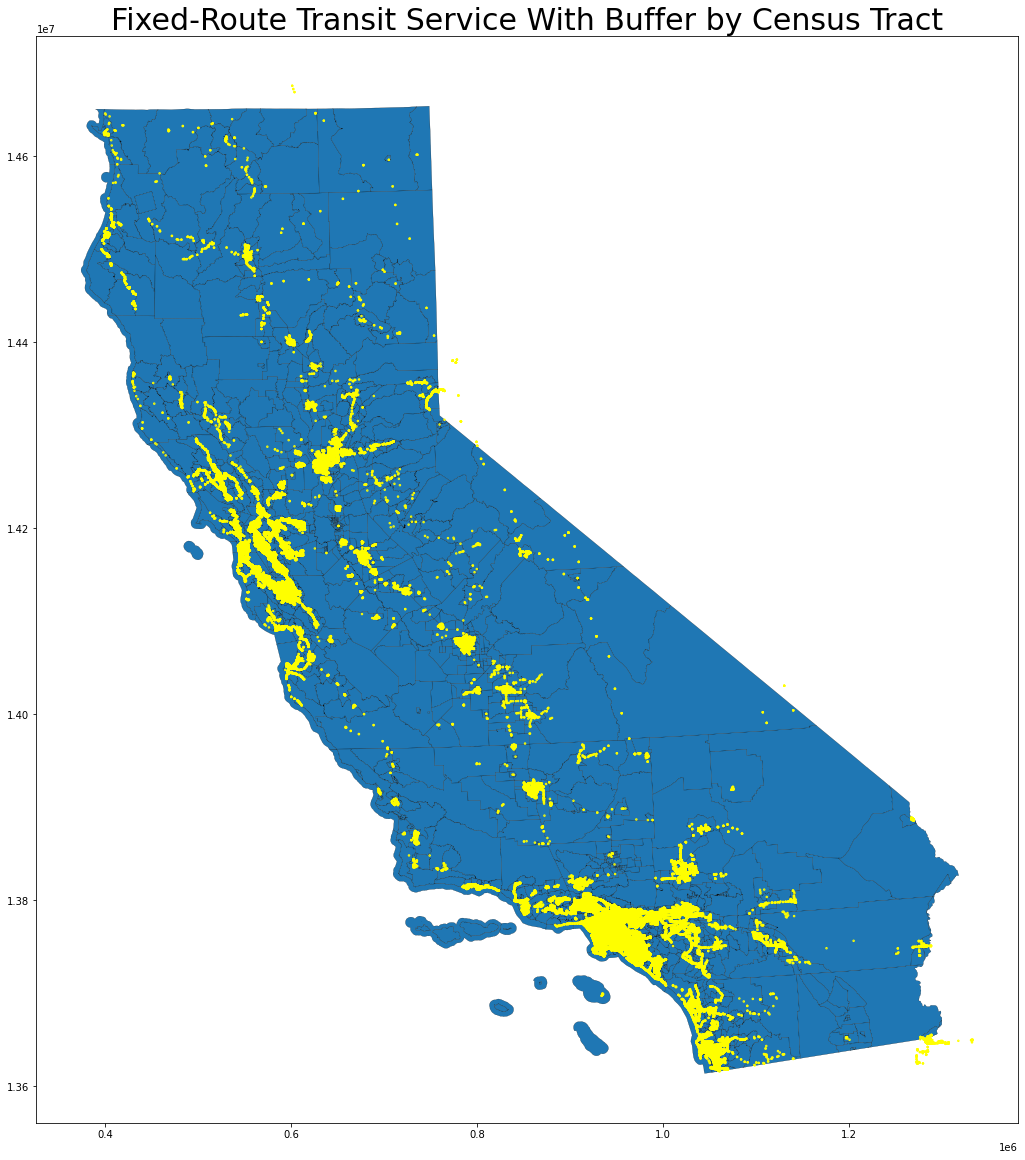

In [5]:
tbl_stop_info = (
    tbl.gtfs_schedule.stops()
    >> filter(_.calitp_itp_id != 284)
    >> select(_,_.stop_lon, _.stop_lat)
    #filter out calitp 284 because have no stop lat/long
    >> collect()
)

gdf_stops = geopandas.GeoDataFrame(tbl_stop_info, geometry=geopandas.points_from_xy(tbl_stop_info.stop_lon,tbl_stop_info.stop_lat), crs = "epsg:4326")
gdf_stops_utm = gdf_stops.to_crs(epsg=32710)
census_tracts_utm = census_tracts['geometry'].to_crs(epsg=32710)

gdf_stops_buffer = gdf_stops_utm.geometry.buffer(805)

ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")


plt.title('Fixed-Route Transit Service With Buffer by Census Tract', fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Fixed-Route Transit Service by Census Tract')

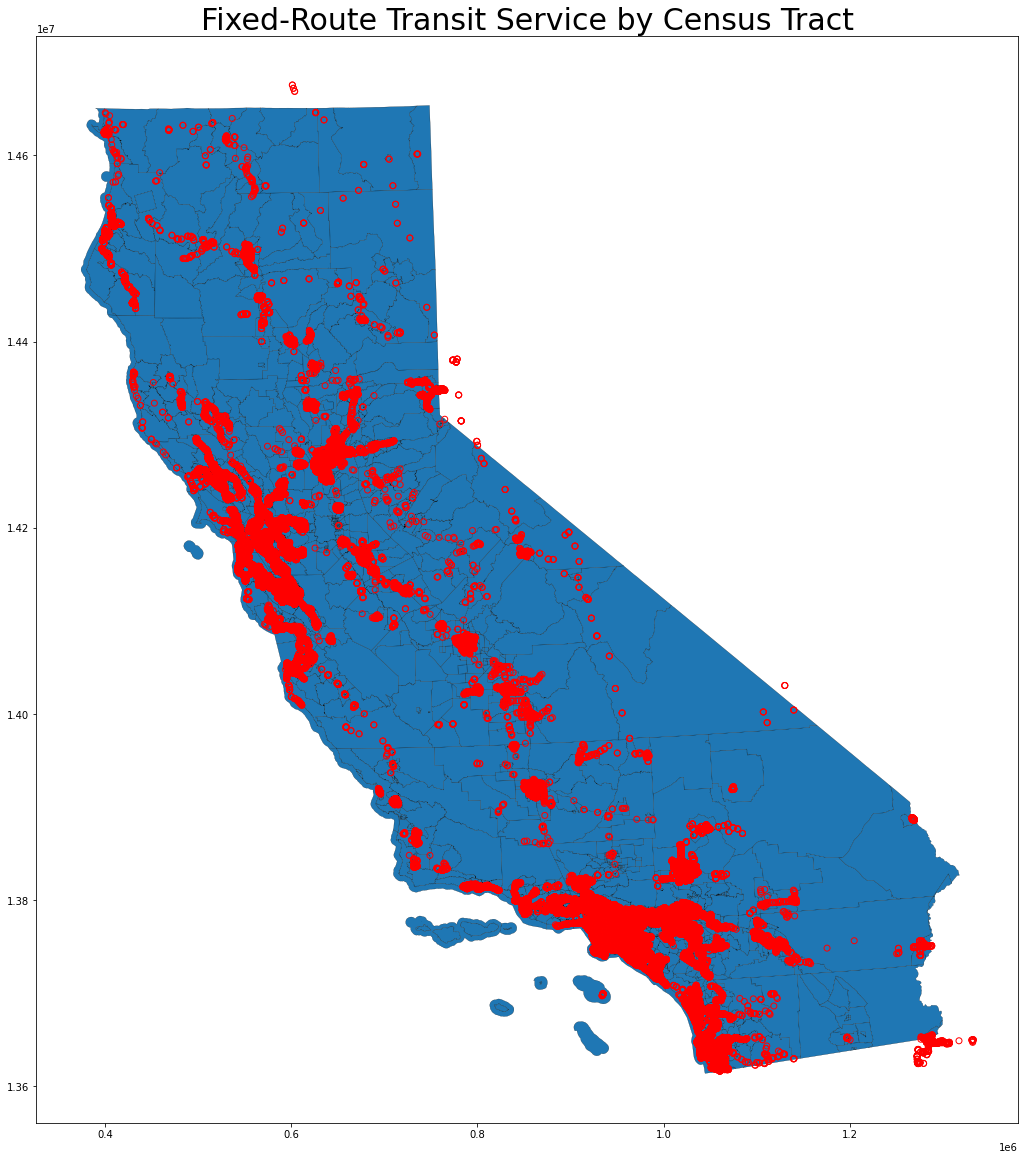

In [6]:
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_utm.plot(ax=ax, color="none", edgecolor="red")
plt.title('Fixed-Route Transit Service by Census Tract', fontsize = 30)

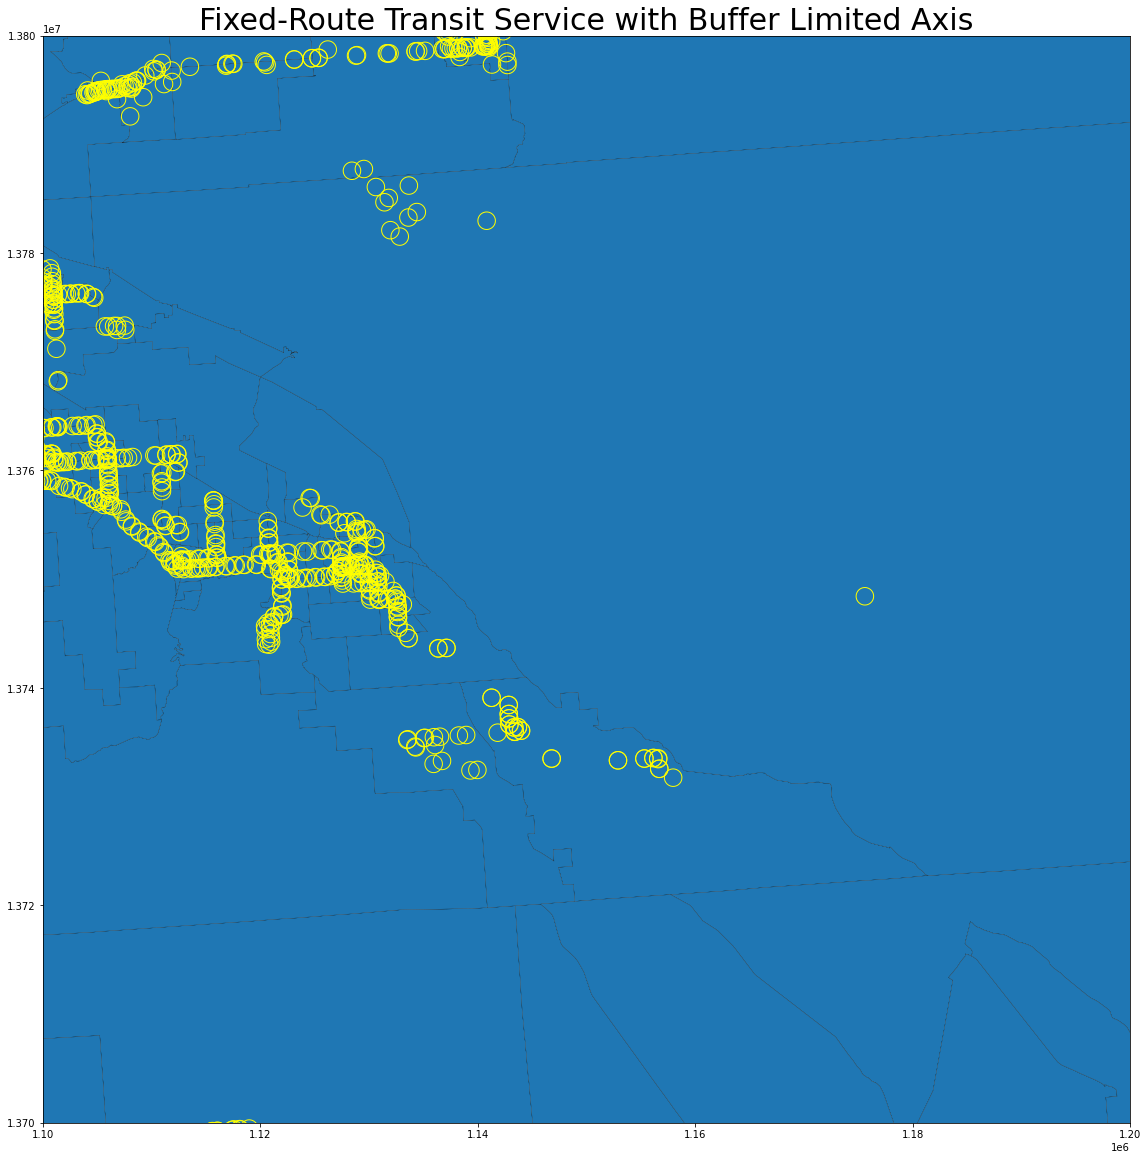

In [7]:
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")
plt.axis([1100000,1200000,13700000,13800000])
plt.title('Fixed-Route Transit Service with Buffer Limited Axis', fontsize = 30)
plt.show()

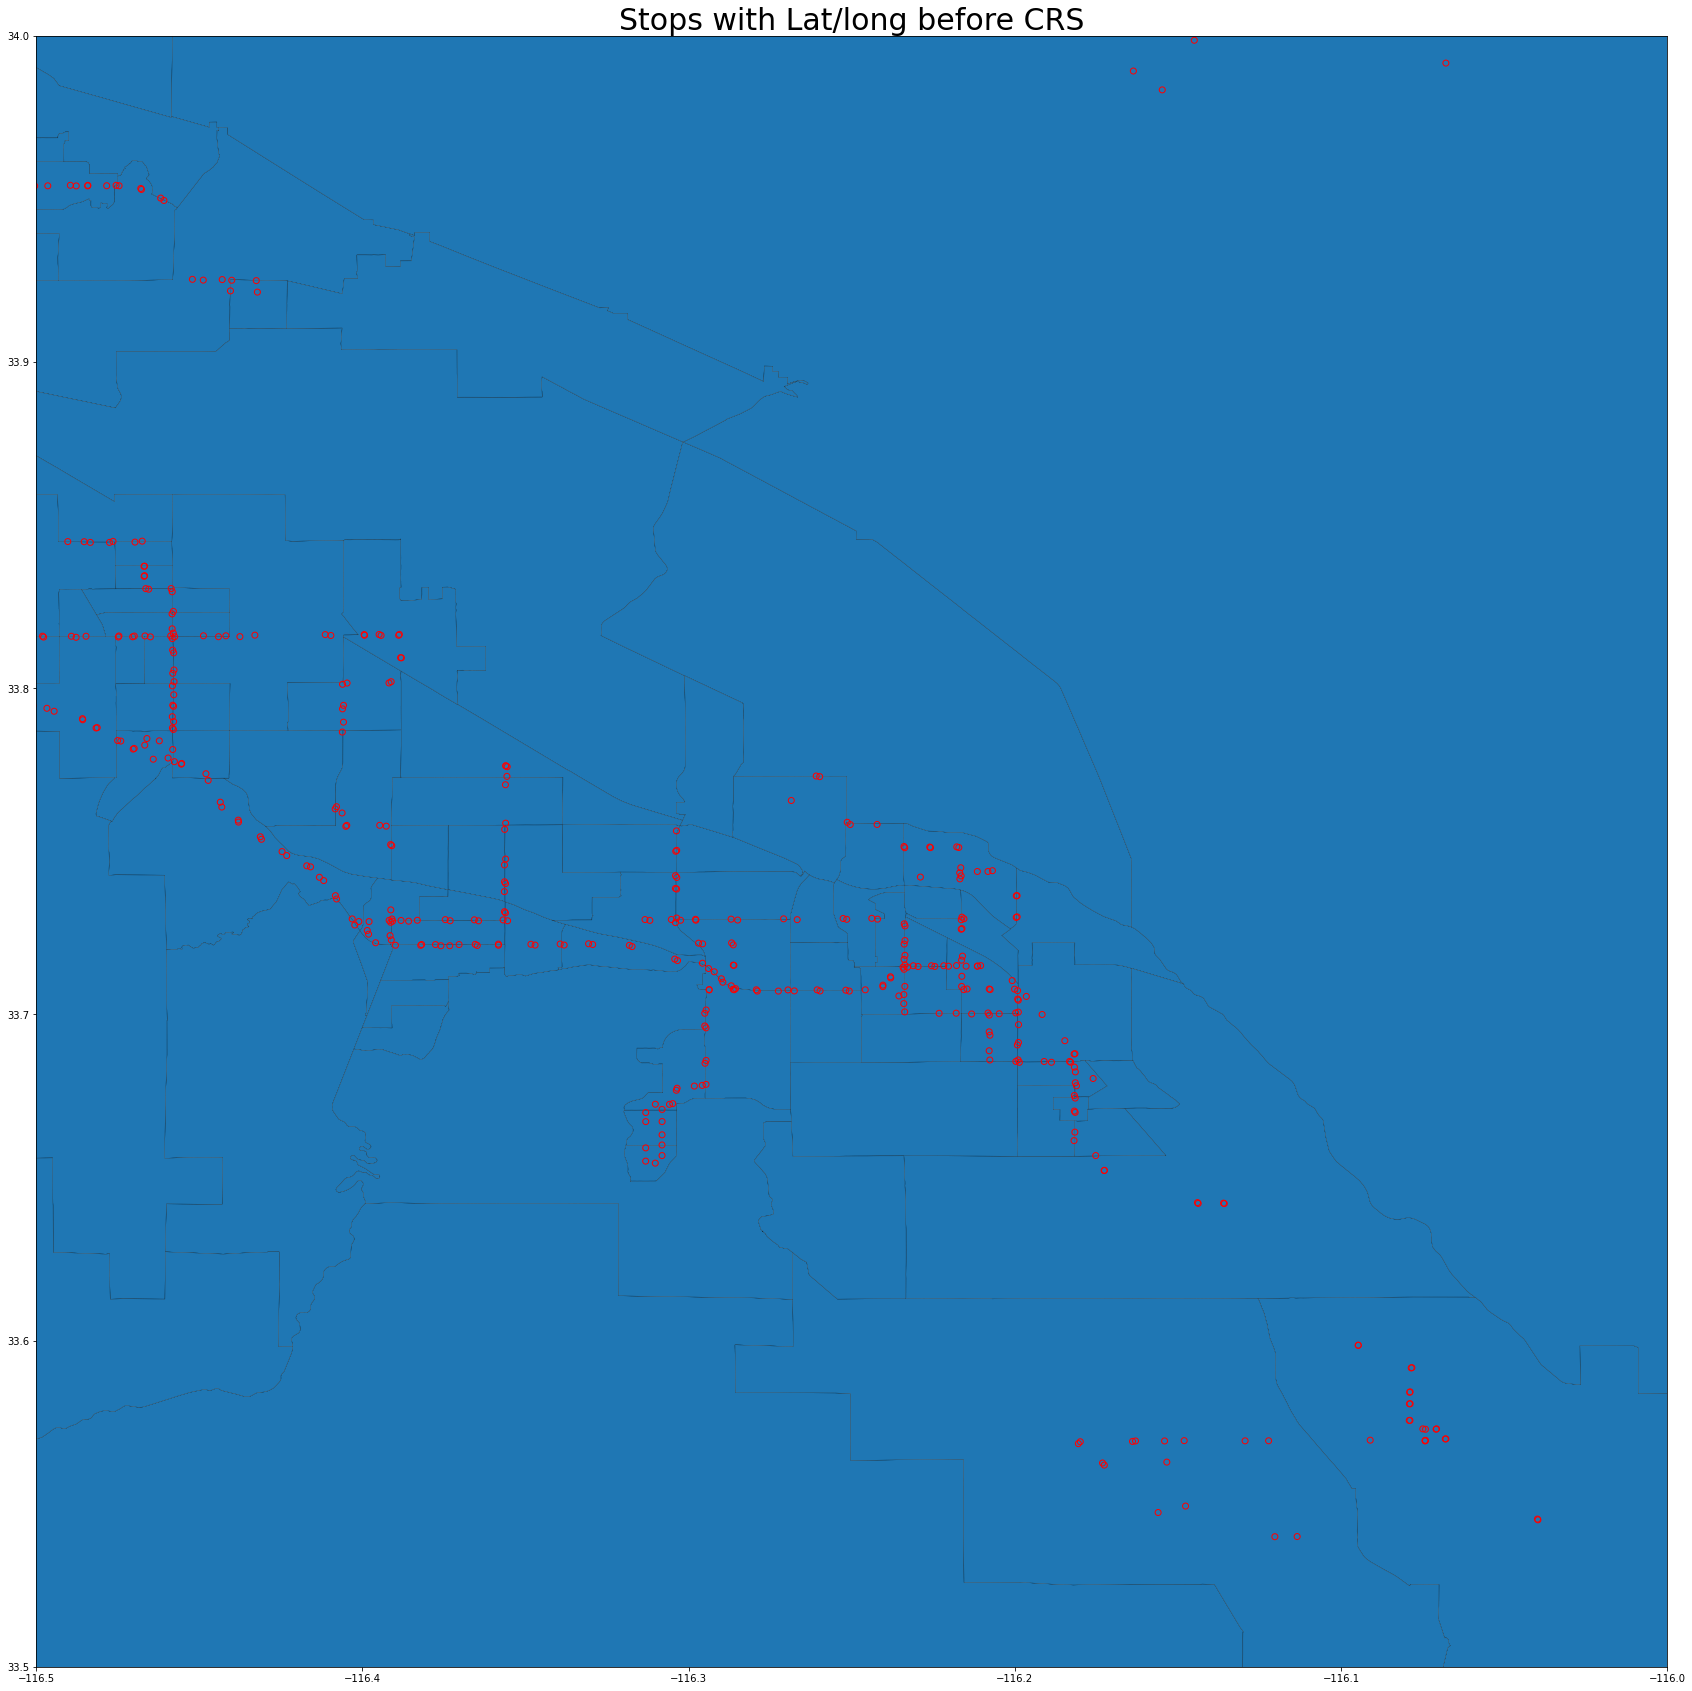

In [8]:
gdf_stops = geopandas.GeoDataFrame(tbl_stop_info, geometry=geopandas.points_from_xy(tbl_stop_info.stop_lon,tbl_stop_info.stop_lat))
ax = census_tracts.plot(edgecolor="black", linewidth=0.2, figsize=(30,30))
gdf_stops.plot(ax=ax, color="none", edgecolor="red")
plt.axis([-116.5,-116,33.5, 34])
plt.title('Stops with Lat/long before CRS', fontsize = 30)
plt.show()

                                
                                   

Calculates the area of intersection between the buffer and each census tract, divides the intersection area by the census tract area to calculate the fraction of the census tract area contained in the intersection, and then multiplies this decimal number by the census tract population to estimate the number of people who live within the specified distance from the stop. The code also adds all of these calculated geometries and values as columns in a new GeoDataFrame named merged.

In [9]:
#calculation of area by using geopandas unary_method to combine them into a single multipolygon
gdf_buffer_union = gdf_stops_buffer.unary_union
multi_polygon = gdf_buffer_union.area
overlap = census_tracts_data.intersection(multi_polygon)


AttributeError: 'DataFrame' object has no attribute 'intersection'

In [ ]:
overlap= census_tracts_data['geometry'].intersection(gdf_buffer_union)
merged = census_tracts_data.join(overlap)
merged['tract_area'] = merged.geometry.area
merged['buffer_area'] = gtfs_stops_buffer.area
merged['pct_overlap'] = merged['buffer_area']/merged['tract_area']
merged['affected_pop'] = [round(merged['pct_overlap'] * merged['ttl_pop'])]
merged['affected_jobs'] = [round(merged['pct_overlap'] * merged['ttl_jobs'])] 

# What is the percent of California served by demand-responsive transit?

# What is the total ridership of demand-responsive transit services?

In [ ]:
ntd_stats = pd.read_csv("Primary List of California Transit Providers - NTD Stats.csv")
ntd_stats_df = pd.DataFrame(ntd_stats)
ntd_stats_df['UPT_DR'] = ntd_stats_df['UPT_DR'].str.replace(',', '').astype(float)
total = ntd_stats_df['UPT_DR'].sum()

## Total ridership of demand-responsive transit services for California is 13,305,747 